In [ ]:

ecommerce_customer_data_large.csv

In [1]:
# 1) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
# XGBoost import is optional; comment out if not installed
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

In [4]:
# %%
# 2) Load data
df = pd.read_csv('ecommerce_customer_data_large.csv', parse_dates=['Purchase Date'])


In [5]:
df

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,33807,2023-01-24 12:32:18,Home,436,1,3664,Cash,63,0.0,Gabriel Williams,63,Male,0
249996,20455,2021-06-04 05:45:25,Electronics,233,1,4374,Credit Card,66,1.0,Barry Foster,66,Female,0
249997,28055,2022-11-10 17:11:57,Electronics,441,5,5296,Cash,63,NaN,Lisa Johnson,63,Female,0
249998,15023,2021-06-27 14:42:12,Electronics,44,2,2517,Cash,64,1.0,Melissa Fernandez,64,Male,0


In [6]:
# Quick top-level overview
print('Rows:', len(df))
print(df.columns.tolist())
df.head()

Rows: 250000
['Customer ID', 'Purchase Date', 'Product Category', 'Product Price', 'Quantity', 'Total Purchase Amount', 'Payment Method', 'Customer Age', 'Returns', 'Customer Name', 'Age', 'Gender', 'Churn']


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [7]:
# 3) Basic cleaning & sanity checks
# Standardize column names (no leading/trailing spaces)
df.columns = [c.strip() for c in df.columns]

In [8]:
# Ensure numeric columns are numeric
for col in ['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 'Returns', 'Churn']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [9]:
# Drop rows with missing customer id
df = df.dropna(subset=['Customer ID'])

In [10]:
# Show null counts
print('\nMissing values by column:')
print(df.isna().sum())


Missing values by column:
Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47382
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64


In [11]:
# 4) Convert transactional data to customer-level features
# We'll aggregate purchase-level transactions to per-customer features for churn prediction

agg_funcs = {
    'Total Purchase Amount': ['sum','mean','max'],
    'Purchase Date': ['min','max','count'],
    'Quantity': 'sum',
    'Returns': 'sum'
}

In [12]:

cust = df.groupby('Customer ID').agg(agg_funcs)
# flatten columns
cust.columns = ['_'.join(col).strip() for col in cust.columns.values]

In [13]:
# Rename intuitive columns
cust = cust.rename(columns={
    'Total Purchase Amount_sum': 'total_spent',
    'Total Purchase Amount_mean': 'avg_order_value',
    'Total Purchase Amount_max': 'max_order_value',
    'Purchase Date_min': 'first_purchase_date',
    'Purchase Date_max': 'last_purchase_date',
    'Purchase Date_count': 'num_orders',
    'Quantity_sum': 'total_quantity',
    'Returns_sum': 'total_returns'
})

In [14]:
# Add recency (days since last purchase relative to dataset max date)
dataset_max_date = df['Purchase Date'].max()
cust['days_since_last_purchase'] = (dataset_max_date - pd.to_datetime(cust['last_purchase_date'])).dt.days


In [16]:
# return rate
cust['return_rate'] = cust['total_returns'] / cust['num_orders']

In [17]:
# number of distinct product categories per customer
category_counts = df.groupby('Customer ID')['Product Category'].nunique().rename('num_categories')
cust = cust.merge(category_counts, left_index=True, right_index=True, how='left')


In [18]:
# Payment method mode per customer (we'll take most common payment method)
payment_mode = df.groupby('Customer ID')['Payment Method'].agg(lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan).rename('payment_method')
cust = cust.merge(payment_mode, left_index=True, right_index=True, how='left')


In [19]:
# Gender and Age from first (or most frequent) row
age = df.groupby('Customer ID')['Customer Age'].agg(lambda x: x.iloc[0]).rename('age')
gender = df.groupby('Customer ID')['Gender'].agg(lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan).rename('gender')
name = df.groupby('Customer ID')['Customer Name'].agg(lambda x: x.iloc[0]).rename('customer_name')


In [20]:
cust = cust.merge(age, left_index=True, right_index=True, how='left')
cust = cust.merge(gender, left_index=True, right_index=True, how='left')
cust = cust.merge(name, left_index=True, right_index=True, how='left')


In [21]:

# Churn label (assumes churn is present at transaction-level; we take max per customer)
if 'Churn' in df.columns:
    churn_label = df.groupby('Customer ID')['Churn'].max().rename('churn')
    cust = cust.merge(churn_label, left_index=True, right_index=True, how='left')
else:
    raise ValueError('Churn column not found in input CSV')


In [22]:
# Some derived features
cust['orders_per_month'] = cust['num_orders'] / ((cust['last_purchase_date'] - cust['first_purchase_date']).dt.days/30.0 + 0.001)
cust['avg_items_per_order'] = cust['total_quantity'] / cust['num_orders']


In [23]:

# Fill inf/nan for derived
cust.replace([np.inf, -np.inf], np.nan, inplace=True)
cust['return_rate'] = cust['return_rate'].fillna(0)


In [24]:
# Preview
cust.reset_index().head()

,Customer ID,total_spent,avg_order_value,max_order_value,first_purchase_date,last_purchase_date,num_orders,total_quantity,total_returns,days_since_last_purchase,return_rate,num_categories,payment_method,age,gender,customer_name,churn,orders_per_month,avg_items_per_order
0,1,6290,2096.666667,5148,2020-03-04 10:26:02,2022-11-29 06:48:25,3,15,0.0,288,0.000000,3,Credit Card,67,Female,Dominic Cline,0,0.090087,5.00
1,2,16481,2746.833333,4777,2020-07-31 16:27:41,2023-07-03 17:26:19,6,18,4.0,72,0.666667,4,PayPal,42,Female,Crystal Day,0,0.168693,3.00
2,3,9423,2355.750000,4687,2020-01-19 00:03:00,2023-02-03 03:58:07,4,15,0.0,222,0.000000,3,Credit Card,31,Male,Joseph Perez,0,0.108008,3.75
3,4,7826,1565.200000,2959,2020-10-12 22:03:10,2022-06-29 03:41:09,5,19,3.0,441,0.600000,4,Cash,37,Male,Wyatt Love,0,0.240373,3.80
4,5,9769,1953.800000,4227,2020-04-08 21:57:19,2022-07-16 04:08:09,5,13,3.0,424,0.600000,2,Credit Card,24,Female,Shannon Hoffman,0,0.181153,2.60


In [25]:
# 5) Exploratory Visualizations (matplotlib only)
import matplotlib.pyplot as plt

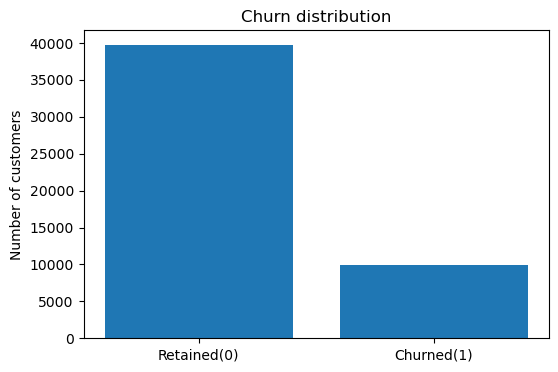

In [26]:
plt.figure(figsize=(6,4))
churn_counts = cust['churn'].value_counts().sort_index()
plt.bar(['Retained(0)','Churned(1)'], churn_counts.values)
plt.title('Churn distribution')
plt.ylabel('Number of customers')
plt.show()

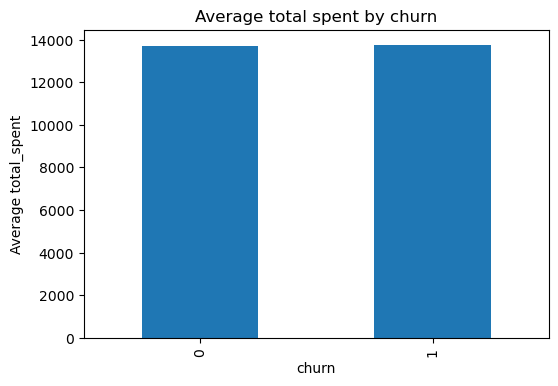

In [27]:
# Average total_spent by churn
plt.figure(figsize=(6,4))
cust.groupby('churn')['total_spent'].mean().plot(kind='bar')
plt.title('Average total spent by churn')
plt.ylabel('Average total_spent')
plt.show()

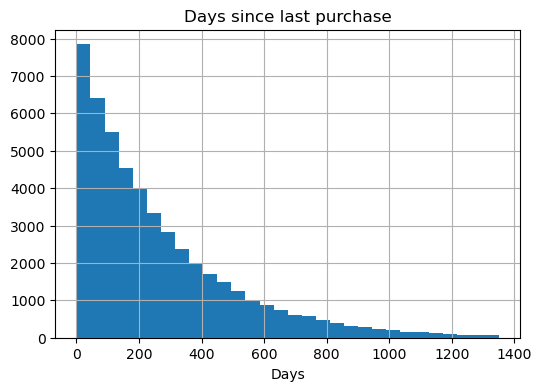

In [28]:
# Days since last purchase distribution
plt.figure(figsize=(6,4))
cust['days_since_last_purchase'].hist(bins=30)
plt.title('Days since last purchase')
plt.xlabel('Days')
plt.show()

In [29]:
# 6) Prepare data for modeling
# Select features and target
features = ['total_spent','avg_order_value','max_order_value','num_orders','orders_per_month','avg_items_per_order','return_rate','num_categories','days_since_last_purchase','age','gender','payment_method']
X = cust[features].copy()
y = cust['churn'].astype(int)

In [30]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [31]:
# %%
# 7) Build preprocessing pipeline
numeric_features = ['total_spent','avg_order_value','max_order_value','num_orders','orders_per_month','avg_items_per_order','return_rate','num_categories','days_since_last_purchase','age']
cat_features = ['gender','payment_method']

In [32]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [33]:

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', cat_transformer, cat_features)
    ]
)

In [35]:
# 8) Train models (Logistic Regression & Random Forest, optional XGBoost)
models = {
    'logreg': Pipeline(steps=[('preprocessor', preprocessor), ('clf', LogisticRegression(max_iter=1000))]),
    'rf': Pipeline(steps=[('preprocessor', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])
}

In [36]:

if xgb_available:
    models['xgb'] = Pipeline(steps=[('preprocessor', preprocessor), ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))])


In [37]:
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print(f"Done {name}")

Training logreg...
Done logreg
Training rf...
Done rf


In [38]:
# 9) Evaluate models

def eval_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    print(classification_report(y_test, y_pred))
    if y_proba is not None:
        print('ROC AUC:', roc_auc_score(y_test, y_proba))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:\n', cm)

for name, model in trained_models.items():
    print('\n====== MODEL:', name, '======')
    eval_model(model, X_test, y_test)


====== MODEL: logreg ======
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      7947
           1       0.00      0.00      0.00      1986

    accuracy                           0.80      9933
   macro avg       0.40      0.50      0.44      9933
weighted avg       0.64      0.80      0.71      9933

ROC AUC: 0.4998671967139804
Confusion matrix:
 [[7947    0]
 [1986    0]]

====== MODEL: rf ======


C:\Users\visha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\visha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\visha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89      7947
           1       0.00      0.00      0.00      1986

    accuracy                           0.80      9933
   macro avg       0.40      0.50      0.44      9933
weighted avg       0.64      0.80      0.71      9933

ROC AUC: 0.4983442357481356
Confusion matrix:
 [[7945    2]
 [1986    0]]


In [40]:
# %%
# 11) Save the best model (choose by ROC AUC on test)
best_name, best_score = None, -1
for name, model in trained_models.items():
    if hasattr(model, 'predict_proba'):
        score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    else:
        score = f1_score(y_test, model.predict(X_test))
    if score > best_score:
        best_score = score
        best_name = name

print('\nBest model:', best_name, 'score:', best_score)



Best model: logreg score: 0.4998671967139804


In [41]:
import joblib
joblib.dump(trained_models[best_name], 'best_churn_model.pkl')
print('Saved best model to best_churn_model.pkl')

Saved best model to best_churn_model.pkl


In [42]:
# %%
# 12) Quick helper: predict churn for a new customer row (example)

def predict_single(customer_row_dict):
    # customer_row_dict should contain same keys as features list
    row = pd.DataFrame([customer_row_dict])
    model = joblib.load('best_churn_model.pkl')
    pred = model.predict(row)
    prob = model.predict_proba(row)[:,1] if hasattr(model, 'predict_proba') else None
    return int(pred[0]), float(prob[0]) if prob is not None else None

In [44]:
# Example: active customer, likely to stay
example_customer = {
    'total_spent': 2500,
    'avg_order_value': 250,
    'max_order_value': 500,
    'num_orders': 10,
    'orders_per_month': 2,
    'avg_items_per_order': 3,
    'return_rate': 0.1,
    'num_categories': 5,
    'days_since_last_purchase': 5,
    'age': 32,
    'gender': 'Female',
    'payment_method': 'Credit Card'
}

# Example: inactive customer, likely to churn
example_churn_risk = {
    'total_spent': 200,
    'avg_order_value': 50,
    'max_order_value': 60,
    'num_orders': 4,
    'orders_per_month': 0.2,
    'avg_items_per_order': 1,
    'return_rate': 0.5,
    'num_categories': 1,
    'days_since_last_purchase': 300,
    'age': 45,
    'gender': 'Male',
    'payment_method': 'PayPal'
}


In [45]:
pred, prob = predict_single(example_customer)
print("Prediction:", "Churn" if pred == 1 else "Retained", "| Probability:", prob)

pred, prob = predict_single(example_churn_risk)
print("Prediction:", "Churn" if pred == 1 else "Retained", "| Probability:", prob)


Prediction: Retained | Probability: 0.21037510387837846
Prediction: Retained | Probability: 0.20201296199113525
